# Maxwell solver in two dimensions with FDTD scheme

$$
\frac{\partial H_z}{\partial t} = \frac{\partial E_x}{\partial y} - \frac{\partial E_y}{\partial x}
;\qquad
\frac{\partial E_x}{\partial t} = \frac{\partial H_z}{\partial y}
;\qquad
\frac{\partial E_y}{\partial t} = - \frac{\partial H_z}{\partial x} 
$$

[Description of the scheme](https://en.wikipedia.org/wiki/Finite-difference_time-domain_method)

![fdtd](images/fdtd.png)

$$
H_z \big|^{n+1/2}_{i+1/2,j+1/2} = H_z \big|^{n-1/2}_{i+1/2,j+1/2} + 
\frac{dt}{dy} \big(E_x \big|^{n}_{i+1/2,j+1} - E_x \big|^{n}_{i+1/2,j} \big)
- \frac{dt}{dx} \big( E_y \big|^{n}_{i+1,j+1/2} - E_y \big|^{n}_{i,j+1/2} \big)
$$

$$
E_x \big|^{n+1}_{i+1/2,j} = E_x \big|^{n}_{i+1/2,j} + \frac{dt}{dy} \big( H_z \big|^{n+1/2}_{i+1/2,j+1/2} - H_z \big|^{n+1/2}_{i-1/2, j-1/2} \big)
$$

$$
E_y \big|^{n+1}_{i,j+1/2} = E_y \big|^{n}_{i,j+1/2} - \frac{dt}{dx} \big( H_z \big|^{n+1/2}_{i+1/2,j+1/2} - H_z \big|^{n+1/2}_{i-1/2, j+1/2} \big)
$$



In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
from IPython.display import HTML


plt.rcParams['figure.figsize'] = (10,6)

In [43]:
# Mesh parameters
nx, ny = 101, 101
vx, dx = np.linspace(0, 1, nx, endpoint=True, retstep=True)
vy, dy = np.linspace(0, 1, ny, endpoint=True, retstep=True)

#Initialize Ex, Ey when time = 0
ex = np.zeros((nx-1, ny), dtype=np.double)  
ey = np.zeros((nx, ny-1), dtype=np.double) 
nbiter = 500   # time loop size
dt = 0.001     # time step
m, n = 2, 2
omega = np.sqrt((m*np.pi)**2+(n*np.pi)**2)
# Create the staggered grid for Bz
x, y = np.meshgrid(0.5*(vx[:-1]+vx[1:]), 0.5*(vy[:-1]+vy[1:]))

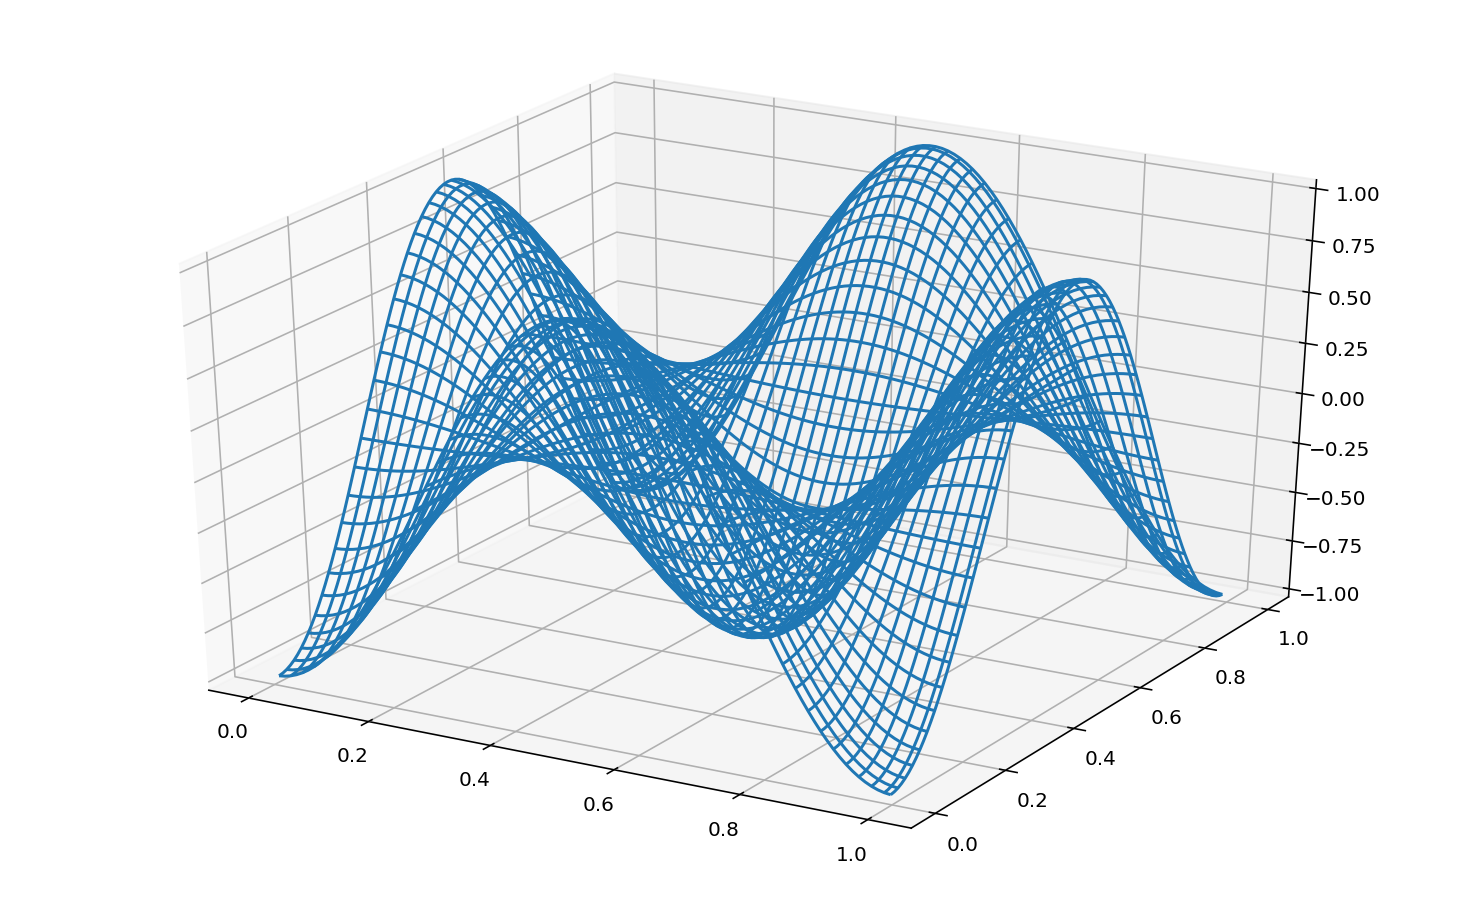

In [44]:
fig = plt.figure()
ax = axes3d.Axes3D(fig)

#Initialize Bz when time = - dt / 2
hz = - np.cos(m*np.pi*y) * np.cos(n*np.pi*x) * np.cos(omega*(-0.5*dt))
wframe = ax.plot_wireframe(x, y, hz, rstride=2, cstride=2)
ax.set_zlim(-1,1);

## numpy

In [55]:
def faraday( ex, ey, hz ) : 
    "faraday equation Bz(t+dt/2) -> Bz(t-dt/2) + dt f(E(t))"
    return hz + dt * ((ex[:, 1:]-ex[:, :-1]) / dy - (ey[1:, :]-ey[:-1, :]) / dx)

def ampere_maxwell( hz, ex, ey):
    " Ampere-Maxwell equation E(t+dt) -> E(t) + dt g(Bz(t+dt/2)) "
    ex[:, 1:-1] += dt*(hz[:, 1:]-hz[:, :-1]) / dy
    ey[1:-1, :] += - dt*(hz[1:, :]-hz[:-1, :]) / dx

    # periodic boundary conditions
    ex[:, 0] += dt*(hz[:, 0]-hz[:, -1]) / dy
    ex[:, -1] = ex[:, 0]
    ey[0, :] += - dt*(hz[0, :]-hz[-1, :]) / dx
    ey[-1, :] = ey[0, :]
    
    return ex, ey

In [46]:
def update(i, ax, fig):
    ax.cla()

    global ex, ey, hz

    hz = faraday( ex, ey, hz)
    ex, ey = ampere_maxwell( hz, ex, ey)
    
    wframe = ax.plot_wireframe(x, y, hz, rstride=2, cstride=2)
    ax.set_zlim(-1, 1)
    return wframe,

In [47]:
ani = animation.FuncAnimation(fig, update,
                              frames=range(200),
                              fargs=(ax, fig), interval=100)

In [48]:
%%time
HTML(ani.to_html5_video())

CPU times: user 21.3 s, sys: 498 ms, total: 21.8 s
Wall time: 21.9 s


In [49]:
%%time

from tqdm import tqdm_notebook as tqdm

ex.fill(0.0)
ey.fill(0.0)
hz = - np.cos(m*np.pi*y) * np.cos(n*np.pi*x) * np.cos(omega*(-0.5*dt))

for t in tqdm(range(1000)):
    
    hz = faraday( ex, ey, hz)
    ex, ey = ampere_maxwell( hz, ex, ey)
    



CPU times: user 170 ms, sys: 5.87 ms, total: 176 ms
Wall time: 173 ms


In [50]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [51]:
%%fortran 

subroutine faraday( ex, ey, bz, dx, dy, dt, nx, ny)
implicit none

real(8), intent(in) :: ex(nx-1,ny)
real(8), intent(in) :: ey(nx,ny-1)
real(8), intent(inout) :: bz(nx-1,ny-1)
integer, intent(in) :: nx, ny
real(8), intent(in) :: dx, dy, dt

integer :: i, j
real(8) :: dex_dx, dey_dy
real(8) :: dex_dy, dey_dx
        
do j=1,ny-1
do i=1,nx-1
   dex_dy  = (ex(i,j+1)-ex(i,j)) / dy
   dey_dx  = (ey(i+1,j)-ey(i,j)) / dx
   bz(i,j) = bz(i,j) +  dt * (dex_dy - dey_dx)
end do
end do

end subroutine faraday

In [52]:
%%fortran

subroutine amperemaxwell(ex, ey, bz, dx, dy, dt, nx, ny)
implicit none
integer, intent(in):: nx, ny
real(8), intent(in):: dx, dy, dt
real(8), dimension(nx-1, ny-1), intent(inout) :: bz
real(8), dimension(nx-1, ny),   intent(inout) :: ex
real(8), dimension(nx, ny-1),   intent(inout) :: ey
integer:: i, j
real(8):: dbz_dx, dbz_dy
real(8), parameter:: csq = 1d0

do i = 1, nx-1
   dbz_dy = (bz(i, 1)-bz(i, ny-1)) / dy ! periodic BC
   ex(i, 1) = ex(i, 1) + dt*csq*dbz_dy
   ex(i, ny) = ex(i, 1)
end do

do j = 1, ny-1
   dbz_dx = (bz(1,j)-bz(nx-1,j)) / dx  ! periodic BC
   ey(1,j) = ey(1,j) - dt*csq*dbz_dx
   ey(nx,j) = ey(1,j)
end do

do j=2,ny-1
    do i=1,nx-1
       dbz_dy = (bz(i,j)-bz(i,j-1)) / dy
       ex(i,j) = ex(i,j) + dt*csq*dbz_dy 
    end do
end do

do j=1,ny-1
    do i=2,nx-1
       dbz_dx = (bz(i,j)-bz(i-1,j)) / dx
       ey(i,j) = ey(i,j) - dt*csq*dbz_dx 
    end do
end do



end subroutine amperemaxwell

In [53]:
%%time

from tqdm import tqdm_notebook as tqdm

ex.fill(0.0)
ey.fill(0.0)
hz = - np.cos(m*np.pi*y) * np.cos(n*np.pi*x) * np.cos(omega*(-0.5*dt))
ex = np.asfortranarray(ex)
ey = np.asfortranarray(ey)
hz = np.asfortranarray(hz)

for t in tqdm(range(1000)):
    
    faraday( ex, ey, hz, dx, dy, dt, nx, ny)
    amperemaxwell(ex, ey, hz, dx, dy, dt, nx, ny)




CPU times: user 65.2 ms, sys: 5.04 ms, total: 70.2 ms
Wall time: 68.2 ms
